## RSS-Feed Text Analyzer
The code starts by extracting article titles and summaries from an RSS feed, then pre-processes the text by tokenizing, removing stopwords and punctuation, and converting to lowercase. It then creates a word cloud, removes the most common words and bigrams, and creates another word cloud. Next, it tokenizes the content into sentences, vectorizes the sentences using TF-IDF with a focus on bigrams, calculates the average TF-IDF scores for each bigram across all sentences, and displays a word cloud of the top bigrams based on average TF-IDF scores.

#### Import libraries

In [1]:
# Extracting articles from RSS feeds
import feedparser

from bs4 import BeautifulSoup
import os
import json
import string
import nltk

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

#nltk.download('punkt')
#nltk.download('stopwords')

#### Get English stopwords

In [2]:
stopwords = nltk.corpus.stopwords.words('english')
# add words that don't add meaning to the wordclouds
additional_stopwords = ['well', 'among', 'show', 'often', 'specific', 'shows', 'suggests', 'disorder', 'year']
stopwords.extend(additional_stopwords)

#### Choose an url for the RSS-feed
RSS, which stands for Really Simple Syndication, is a web feed that allows users and applications to access updates to websites in a standardized, computer-readable format. These feeds can, for example, allow a user to keep track of many different websites in a single news aggregator. The news aggregator will automatically check the RSS feed for new content, allowing the content to be automatically passed from website to user.

In [55]:
url = 'https://www.sciencedaily.com/rss/mind_brain/borderline_personality_disorder.xml'
feed = feedparser.parse(url)

# print first 5 entries
for entry in feed.entries[:5]:
    print(entry)

{'title': 'Neural signature for borderline personality disorder identified', 'title_detail': {'type': 'text/plain', 'language': None, 'base': 'https://www.sciencedaily.com/rss/mind_brain/borderline_personality_disorder.xml', 'value': 'Neural signature for borderline personality disorder identified'}, 'links': [{'rel': 'alternate', 'type': 'text/html', 'href': 'https://www.sciencedaily.com/releases/2023/06/230627191521.htm'}], 'link': 'https://www.sciencedaily.com/releases/2023/06/230627191521.htm', 'summary': 'A new study of a brain region called the rostro-medial prefrontal could potentially advance diagnosis and therapies for Borderline Personality Disorder (BPD).', 'summary_detail': {'type': 'text/html', 'language': None, 'base': 'https://www.sciencedaily.com/rss/mind_brain/borderline_personality_disorder.xml', 'value': 'A new study of a brain region called the rostro-medial prefrontal could potentially advance diagnosis and therapies for Borderline Personality Disorder (BPD).'}, 'p

#### Iterate over entries
Iterate over each entry in the RSS feed. For each entry, it prints the title of the entry, the entire entry content, and the summary of the entry.

In [4]:
for entry in feed.entries:
    print(entry.title)
    print(entry)
    print(entry.summary)
    print('-------')

Neural signature for borderline personality disorder identified
{'title': 'Neural signature for borderline personality disorder identified', 'title_detail': {'type': 'text/plain', 'language': None, 'base': 'https://www.sciencedaily.com/rss/mind_brain/borderline_personality_disorder.xml', 'value': 'Neural signature for borderline personality disorder identified'}, 'links': [{'rel': 'alternate', 'type': 'text/html', 'href': 'https://www.sciencedaily.com/releases/2023/06/230627191521.htm'}], 'link': 'https://www.sciencedaily.com/releases/2023/06/230627191521.htm', 'summary': 'A new study of a brain region called the rostro-medial prefrontal could potentially advance diagnosis and therapies for Borderline Personality Disorder (BPD).', 'summary_detail': {'type': 'text/html', 'language': None, 'base': 'https://www.sciencedaily.com/rss/mind_brain/borderline_personality_disorder.xml', 'value': 'A new study of a brain region called the rostro-medial prefrontal could potentially advance diagnosi

#### Append article titles and summaries

In [5]:
articles = []
for e in feed.entries:
  articles.append({'title': e.title, 'summary': e.summary})

#### Save in .json format
In this step, the content of the articles, which is a list of dictionaries containing the titles and summaries of the feed entries, is saved to a file in JSON format. JSON is a lightweight data interchange format that is easy for humans to read and write, and easy for machines to parse and generate. It is often used for transmitting data in web applications and for storing data. Saving the articles in JSON format makes it easy to access and manipulate the data later, either manually or using a program.

In [6]:
blog_articles_summaries = json.loads(open('feed.json').read())
blog_articles_summaries

# Combine feed summaries
feed_summaries = ''
for article in blog_articles_summaries:
    feed_summaries += article['summary'] + '\n'
    print(article['summary'])
    print('\n')

A new study of a brain region called the rostro-medial prefrontal could potentially advance diagnosis and therapies for Borderline Personality Disorder (BPD).


Psychology research finds that moms with personality disorder symptoms impact their adolescent children who subsequently show a higher likelihood of insecure attachment which can impact their socio-emotional development and mental health.


Children experiencing cognitive problems such as low attention, poor memory or lack of inhibition may later suffer mental health issues as teenagers and young adults, a new study reveals.


Borderline Personality Disorder is treatable. New research is the first to show that adolescent borderline pathology follows a similar downward course after discharge from inpatient treatment previously demonstrated for adults.


Specific sleep problems among babies and very young children can be linked to mental disorders in adolescents, a new study has found.


Individuals with social anxiety disorder h

#### Preprocess text
This function takes a string of text and processes it by:

Converting the entire text to lowercase.
Tokenizing the text into words.
Removing stopwords and punctuation from the tokens.
Joining the cleaned tokens back into a string of text.
The purpose of this function is to clean the text by removing common words and punctuation that do not contribute much to the meaning of the text. This is a common step in text processing pipelines, especially in natural language processing (NLP) tasks.

In [36]:
def preprocess(text):
    formatted_text = text.lower()
    tokens = nltk.word_tokenize(formatted_text)
    tokens = [word for word in tokens if word not in stopwords]
    formatted_text = ' '.join(element for element in tokens)
    
    return formatted_text
    
formatted_feed_content = preprocess(feed_summaries)
print(formatted_feed_content[:500])

new study brain region called rostro-medial prefrontal could potentially advance diagnosis therapies borderline personality ( bpd ) . psychology research finds moms personality symptoms impact adolescent children subsequently higher likelihood insecure attachment impact socio-emotional development mental health . children experiencing cognitive problems low attention , poor memory lack inhibition may later suffer mental health issues teenagers young adults , new study reveals . borderline person


In [37]:
print(len(feed_summaries), len(formatted_feed_content))

16765 12958


#### Get most frequent words function
This function identifies the most frequent words in a text.

It first removes all punctuation from the text, except for periods, which it replaces with spaces.
It then tokenizes the text into words and counts the frequency of each word.
It calculates how many words to retrieve based on a specified percentage (default is 10%) of the total unique words in the text.
It then returns the specified number of most common words.
In the given script, this function is used with a 5% percentage parameter on the 'formatted_feed_content' text, which means it will return the 5% most common words in that text.

In [38]:
def get_most_frequent_words(text, percentage=10):
    # Remove punctuation except for periods
    translator = str.maketrans('', '', string.punctuation.replace('.', '')) 
    text = text.translate(translator).lower()

    # Replace periods with spaces
    text = text.replace('.', ' ')

    # Split the text into words
    words = text.split()

    # Count the frequency of each word
    word_count = Counter(words)

    # Calculate how many words we want to get
    n = int(len(word_count) * percentage / 100)

    # Get the n most common words
    most_common_words = word_count.most_common(n)

    return most_common_words
    
most_common_words = get_most_frequent_words(formatted_feed_content, 5)
print(most_common_words)

[('personality', 49), ('new', 29), ('borderline', 27), ('study', 26), ('disorders', 24), ('people', 21), ('research', 17), ('patients', 17), ('researchers', 15), ('according', 14), ('found', 13), ('mental', 12), ('may', 12), ('bipolar', 11), ('bpd', 10), ('also', 10), ('brain', 9), ('emotional', 9), ('associated', 9), ('behavior', 9), ('health', 8), ('traits', 8), ('psychiatric', 8), ('impulsive', 8), ('risk', 8), ('diagnosis', 7), ('problems', 7), ('treatment', 7), ('individuals', 7), ('mood', 7), ('depression', 7), ('therapy', 7), ('impulsivity', 7), ('symptoms', 6), ('children', 6), ('higher', 6), ('social', 6)]


#### Function for removing the most frequent words (to clean-up text and get only meaningful terms)
This function removes the most frequent words from the text.

It first converts the list of most common words into a set for faster lookup.
It then replaces all periods in the text with spaces and splits the text into words.
It filters out the words that are in the most_common_words_set, and
Joins the remaining words back into a string.
The result is a string of the original text with the most common words removed.

In the script, this function is used to remove the most common words (identified in the previous step) from the 'formatted_feed_content' text. The result is saved in the 'formatted_feed_content_v2' variable.

In [39]:
def remove_most_frequent_words(text, most_common_words):
    # Create a set for faster lookup
    most_common_words_set = set(word for word, count in most_common_words)
    
    # Replace periods with spaces
    text = text.replace('.', ' ')
    # Split the text into words
    words = text.split()
    # Only keep the words that are not in the most_common_words_set
    words = [word for word in words if word not in most_common_words_set]
    
    # Join the words back into a string
    text = ' '.join(words)
    
    return text

formatted_feed_content_v2 = remove_most_frequent_words(formatted_feed_content, most_common_words)
print(formatted_feed_content_v2[:500])

region called rostro-medial prefrontal could potentially advance therapies ( ) psychology finds moms impact adolescent subsequently likelihood insecure attachment impact socio-emotional development experiencing cognitive low attention , poor memory lack inhibition later suffer issues teenagers young adults , reveals treatable first adolescent pathology follows similar downward course discharge inpatient previously demonstrated adults sleep babies young linked adolescents , anxiety markedly diffe


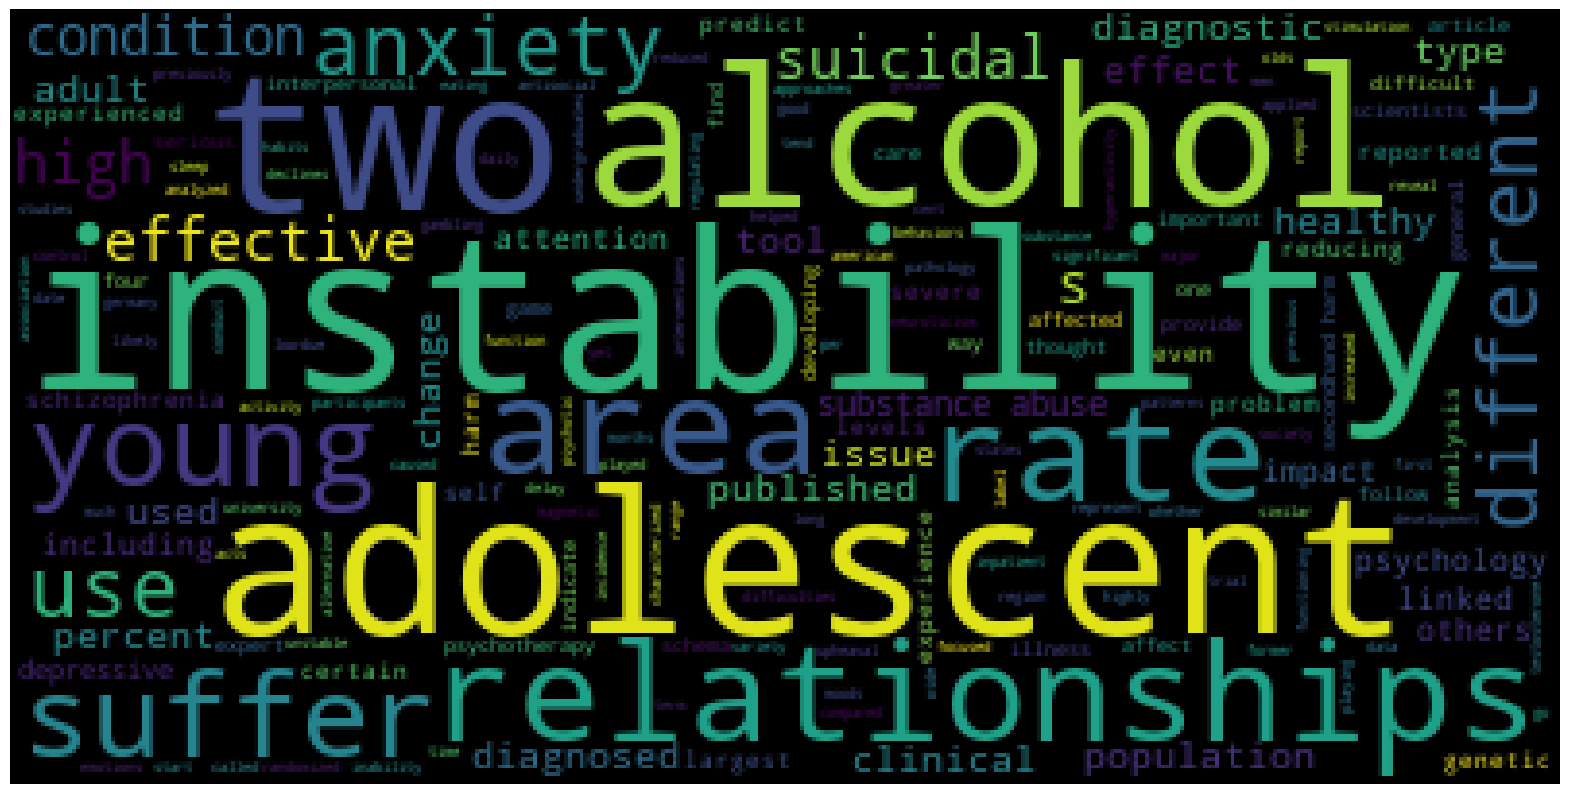

In [11]:
# word cloud
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(WordCloud().generate(formatted_feed_content_v2));

#### Get most frequent bigrams function
This function extracts the most frequent bigrams (pairs of adjacent words) from the text.

It first splits the text into words and filters out any non-alphabetic strings.
It then generates a list of all bigrams in the text.
It counts the frequency of each bigram and stores it in a dictionary.
It calculates how many bigrams to keep based on the given percentage (default is 5%).
It then sorts the bigrams by frequency and returns the specified percentage of the most common bigrams.
In the script, this function is used to extract the most common bigrams from the 'formatted_feed_content' text. The result is saved in the 'most_common_bigrams' variable.

In [40]:
def get_most_frequent_bigrams(text, percentage=5):
    # Split the text into words and filter out any non-alphabetic strings
    words = [word for word in re.findall(r'\b\w+\b', text)]
    
    # Generate bigrams
    bigrams = [f"{words[i]}_{words[i+1]}" for i in range(len(words)-1)]
    
    # Count the frequency of each bigram
    bigram_freq = {}
    for bigram in bigrams:
        if bigram in bigram_freq:
            bigram_freq[bigram] += 1
        else:
            bigram_freq[bigram] = 1
            
    # Calculate how many bigrams to keep based on the given percentage
    num_bigrams_to_keep = int(len(bigram_freq) * percentage / 100)

    # Sort and get the most frequent bigrams
    most_common_bigrams = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)[:num_bigrams_to_keep]
    return most_common_bigrams

In [13]:
def remove_most_frequent_bigrams(text, most_common_bigrams):
    # Create a set for faster lookup
    most_common_bigrams_set = set(bigram for bigram, count in most_common_bigrams)
    
    # Split the text into words and filter out any non-alphabetic strings
    words = [word for word in re.findall(r'\b\w+\b', text)]
    # Prepare a list to collect filtered words/bigrams
    filtered_content = []
    
    i = 0
    while i < len(words) - 1:  # iterate until the penultimate word
        # Generate a bigram from the current word and the next word
        bigram = f"{words[i]}_{words[i+1]}"
        
        # If the bigram is one of the most common, skip the next word too
        if bigram in most_common_bigrams_set:
            i += 2  # Move by 2 positions
        else:
            # Add the bigram to the list
            filtered_content.append(bigram)
            i += 2  # Move by 2 positions to account for both words in the bigram

    # If the last word wasn't part of a bigram, add it too
    if i == len(words) - 1:
        filtered_content.append(words[-1])

    # Join the filtered words/bigrams back into a string
    text = ' '.join(filtered_content)
    return text

In [41]:
# Find the most common bigrams
most_common_bigrams = get_most_frequent_bigrams(formatted_feed_content, 2)
formatted_feed_content_v2 = remove_most_frequent_bigrams(formatted_feed_content, most_common_bigrams)
print(most_common_bigrams)

[('borderline_personality', 23), ('new_study', 16), ('personality_disorders', 9), ('new_research', 8), ('mental_health', 7), ('personality_traits', 6), ('according_new', 6), ('personality_bpd', 5), ('researchers_found', 5), ('people_borderline', 4), ('substance_abuse', 4), ('mental_disorders', 3), ('emotional_instability', 3), ('secondhand_harm', 3), ('patients_borderline', 3), ('schema_therapy', 3), ('disorders_new', 3), ('study_researchers', 3), ('research_finds', 2), ('health_issues', 2), ('study_found', 2), ('different_personality', 2), ('study_analyzed', 2), ('psychiatric_disorders', 2), ('disorders_including', 2), ('bipolar_borderline', 2), ('personality_schizophrenia', 2)]


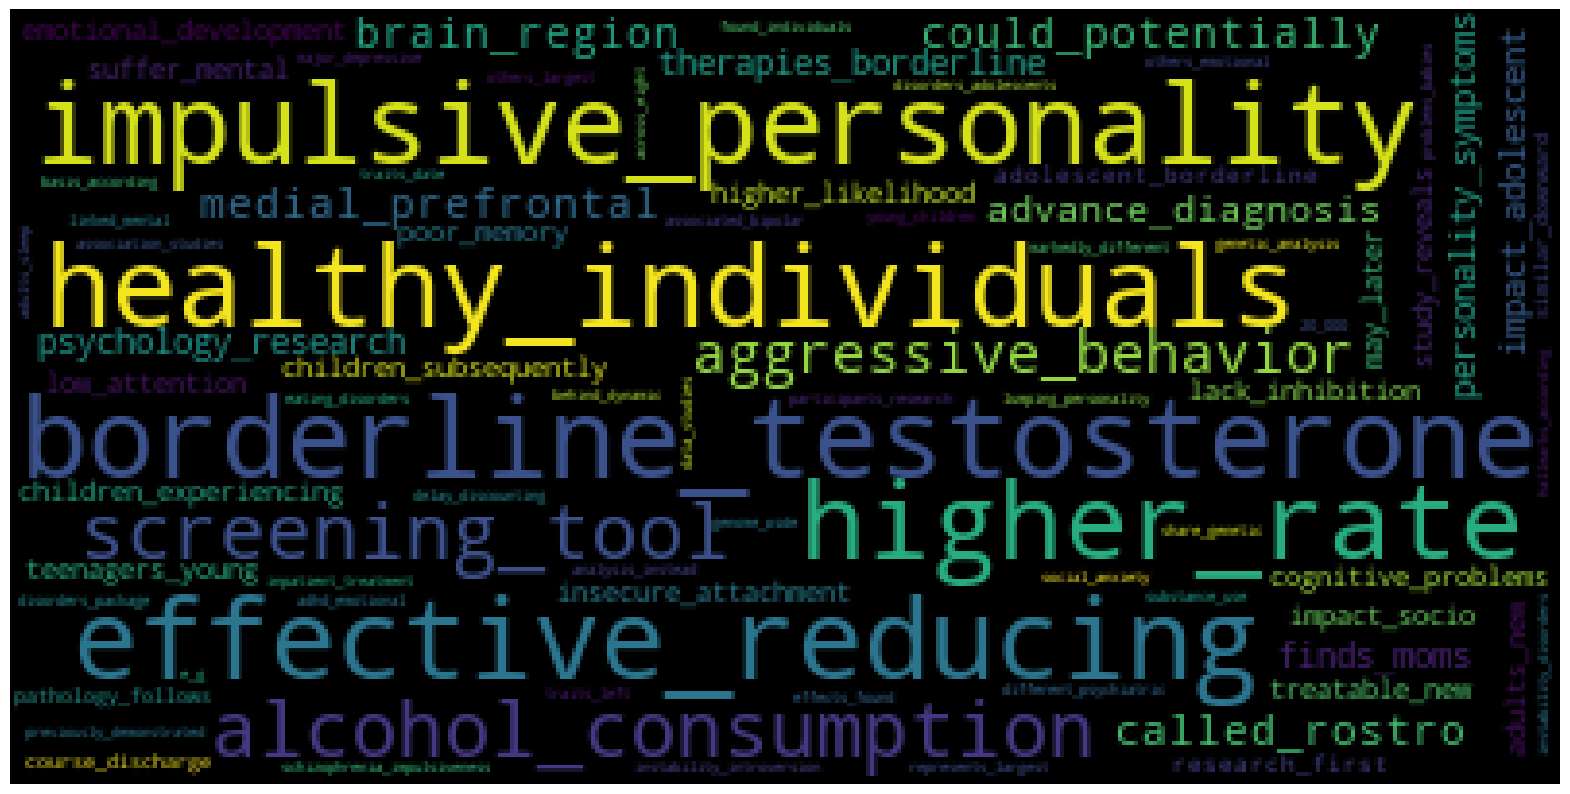

In [42]:
# Generate word cloud
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(WordCloud().generate(formatted_feed_content_v2))
plt.show()

#### Find most important trigrams
The next steps involve using the TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer to find the most important 3-word phrases (or trigrams) in your content.

Split content into sentences: The content is split into sentences. This is a simplistic way to chunk the text. More sophisticated methods like sentence tokenization can be used.

Create TfidfVectorizer: A TfidfVectorizer is created with a focus on trigrams (phrases of 3 words), ignoring common English stopwords and words that appear in more than 85% of the sentences.

Vectorize the sentences: The sentences are then transformed into a sparse matrix of TF-IDF values.

Calculate average TF-IDF scores: The average TF-IDF scores for each trigram across all sentences are calculated. This is done by taking the mean of the TF-IDF matrix along axis 0 (columns).

Sort the trigrams: The trigrams are sorted by their average scores in descending order. The argsort function is used to get the indices that would sort the matrix, and then these indices are used to sort the features (trigrams) and the scores.

Print results: The trigrams and their corresponding average TF-IDF scores are then printed for specific indices.

The resulting trigrams are the ones that have the highest average TF-IDF scores across all sentences, which means they are the most important or informative trigrams in your content.

In [44]:
print(formatted_feed_content[:500])

new study brain region called rostro-medial prefrontal could potentially advance diagnosis therapies borderline personality ( bpd ) . psychology research finds moms personality symptoms impact adolescent children subsequently higher likelihood insecure attachment impact socio-emotional development mental health . children experiencing cognitive problems low attention , poor memory lack inhibition may later suffer mental health issues teenagers young adults , new study reveals . borderline person


In [45]:
# Split content into chunks
sentences = nltk.sent_tokenize(formatted_feed_content)
print("Num sentences: %d" % len(sentences))

Num sentences: 99


In [46]:
# Create a TfidfVectorizer that focuses on bigrams
vectorizer = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', max_df=0.85)
# Vectorize the chunks
X = vectorizer.fit_transform(sentences)
# Calculate the average tf-idf scores for each bigram across all chunks
average_tfidf_scores = np.mean(X, axis=0)
# Sort the bigrams by their average scores in descending order
sorted_indices = np.array(average_tfidf_scores.argsort()[0, ::-1]).flatten()
features = np.array(vectorizer.get_feature_names_out())

print("Bigram for index 143:", features[143])
print("Average TF-IDF for this bigram:", average_tfidf_scores[0, 143])

print("Bigram for index 713:", features[713])
print("Average TF-IDF for this bigram:", average_tfidf_scores[0, 713])

Bigram for index 143: borderline personality bpd
Average TF-IDF for this bigram: 0.011541389304639507
Bigram for index 713: patients previously diagnosed
Average TF-IDF for this bigram: 0.002153542589450611


In [52]:
# Get the top bigrams based on the percentage you want
percentage = 1

# Get the top bigrams based on the percentage you want
num_bigrams_to_keep = int(len(features) * percentage / 100)
top_indices = sorted_indices[:num_bigrams_to_keep]
top_bigrams = features[top_indices]

# Convert the 2D numpy array slice into a 1D array
top_bigrams_1d = top_bigrams.ravel()
# Convert the 1D numpy array into a set
most_common_bigrams_set = set(top_bigrams_1d.tolist())
print(most_common_bigrams_set)

# Create a dictionary of bigrams and their scores
bigrams_scores = {bigram.replace(" ", "_"): average_tfidf_scores[0, i] for i, bigram in enumerate(features)}
# Filter out trigrams containing 'borderline_personality'
filtered_bigrams_scores = {bigram: score for bigram, score in bigrams_scores.items() if 'borderline_personality' not in bigram and 'according_new_study' not in bigram}

# Sort the dictionary based on tf-idf scores and select 20
start_ind = 0
stop_ind = 15
sorted_bigrams_scores = dict(sorted(filtered_bigrams_scores.items(), key=lambda item: item[1], reverse=True)[start_ind:stop_ind])

{'people borderline personality', 'game brains people', 'according new study', 'brains people borderline', 'adhd emotional instability', 'borderline personality treatable', 'individuals mature impulsive', 'borderline personality bpd', 'emotional instability disorders', 'mature impulsive behavior', 'screening tool bipolar'}


In [53]:
print(sorted_bigrams_scores.items())

dict_items([('adhd_emotional_instability', 0.007142492739258057), ('emotional_instability_disorders', 0.007142492739258057), ('individuals_mature_impulsive', 0.007142492739258057), ('mature_impulsive_behavior', 0.007142492739258057), ('screening_tool_bipolar', 0.006263379552005094), ('brains_people_borderline', 0.006104819553413126), ('game_brains_people', 0.006104819553413126), ('psychiatric_disorders_including', 0.006062832450181598), ('impulsivity_strongest_predictor', 0.005831820900905312), ('predictor_overweight_researchers', 0.005831820900905312), ('strongest_predictor_overweight', 0.005831820900905312), ('borderline_testosterone_levels', 0.005534002177578986), ('depression_depressive_symptoms', 0.005534002177578986), ('depressive_symptoms_general', 0.005534002177578986), ('higher_rates_depression', 0.005534002177578986)])


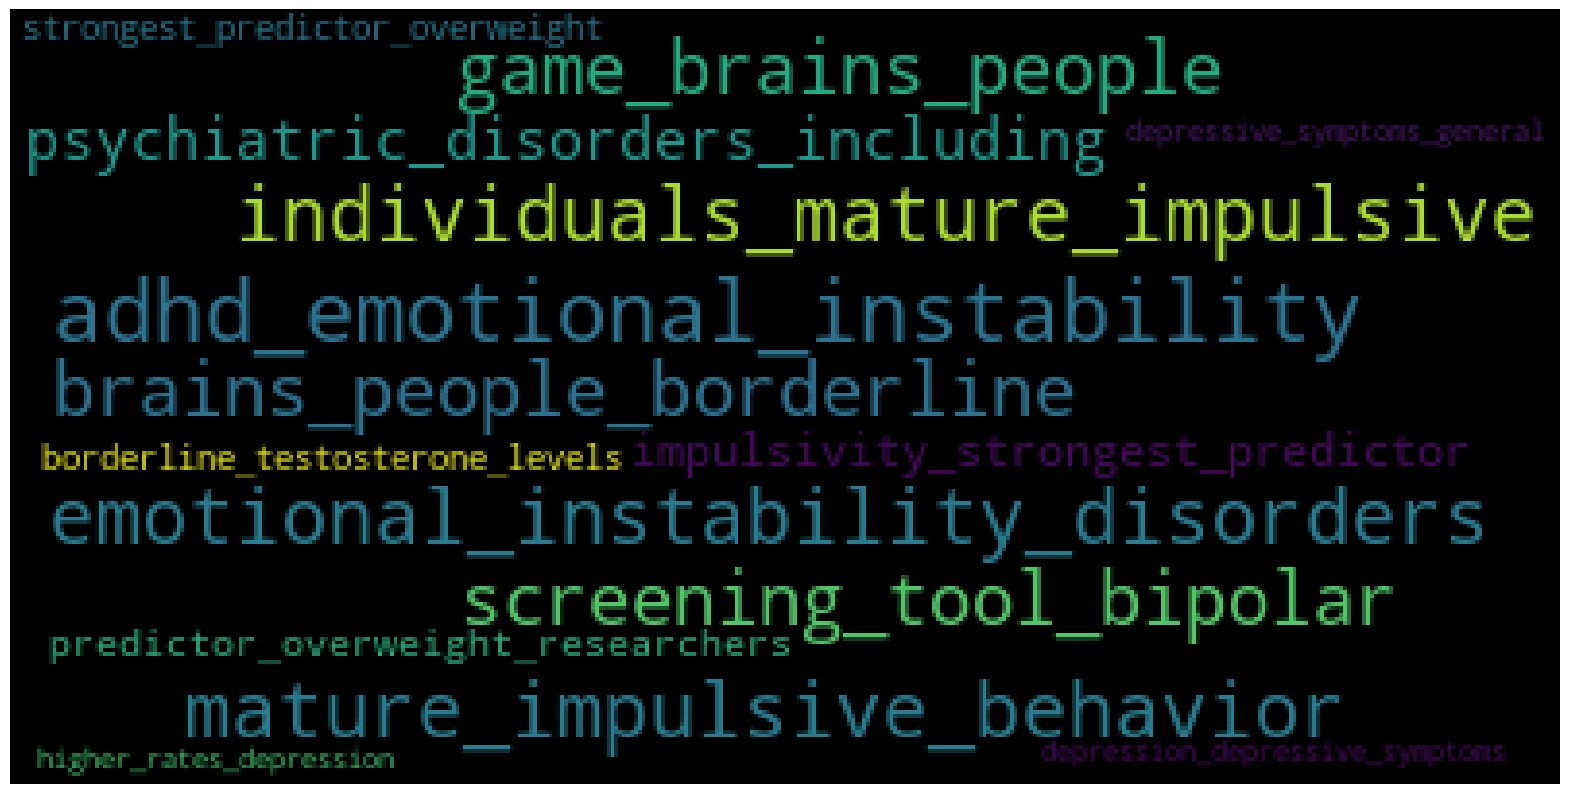

In [54]:
# Generate and display the wordcloud
plt.figure(figsize=(20,20))
plt.axis('off')
wordcloud = WordCloud().generate_from_frequencies(sorted_bigrams_scores)
plt.imshow(wordcloud)
plt.show()

#### Results Discussion
The final word cloud results show the 15 most important trigrams (three-word sequences) from the feed content, based on their TF-IDF scores, after filtering out the unwanted trigrams.

Here are some insights from the results:

Emotional instability is a key theme: The top two trigrams, 'adhd_emotional_instability' and 'emotional_instability_disorders', suggest that emotional instability is strongly associated with BPD and other disorders in the dataset.

Impulsivity and overweight: The trigrams 'impulsivity_strongest_predictor', 'predictor_overweight_researchers', and 'strongest_predictor_overweight' suggest that impulsivity is the strongest predictor of being overweight, according to the researchers in the dataset.

Testosterone levels and depression: The trigrams 'borderline_testosterone_levels', 'higher_rates_depression', and 'depression_depressive_symptoms' suggest that borderline testosterone levels are associated with higher rates of depression and depressive symptoms in the dataset.